# Import data and data exploration

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from icecream import ic
%matplotlib inline

In [2]:
user_ratings_df = pd.read_csv(r'Data\user_ratings.csv',header=0, usecols=['userId','movieId','rating','title'])
user_ratings_df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [3]:
user_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.1+ MB


# Non personalized Recommendation
## Most popular movies

In [19]:
# Get the counts of occurrences of each movie title
movie_popularity = user_ratings_df.title.value_counts()
print(movie_popularity.head().index)

Index(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)'],
      dtype='object')


## Movie with highest average ratings
### Reviews only

In [25]:
user_ratings_df.groupby('title').agg({'rating':['mean']}).sort_values(by=('rating','mean'),ascending=False)

,rating
,mean
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
...,...
Don't Look Now (1973),0.5
Journey 2: The Mysterious Island (2012),0.5


In [30]:
# Find the mean of the ratings given to each title
average_rating_df = user_ratings_df[['title','rating']].groupby('title').mean()

# Order the entries by highest average rating to lowest
sorted_average_ratings = average_rating_df.sort_values(by='rating', ascending=False)

# Inspect the top movies
print(sorted_average_ratings.head())

                                     rating
title                                      
Gena the Crocodile (1969)               5.0
True Stories (1986)                     5.0
Cosmic Scrat-tastrophe (2015)           5.0
Love and Pigeons (1985)                 5.0
Red Sorghum (Hong gao liang) (1987)     5.0


### Combine popularity and reviews

In [42]:
# Create a list of only movies appearing > 50 times in the dataset
movie_popularity = user_ratings_df['title'].value_counts()
popular_movies = movie_popularity[movie_popularity >=50].index
# use popular movies list to filter the original DataFrame
popular_movies_rankings =  user_ratings_df[user_ratings_df.title.isin(popular_movies)]
popular_movies_average_ratings =popular_movies_rankings[['title','rating']].groupby('title').mean()
popular_movies_average_ratings.sort_values(by='rating',ascending = False).head()

,rating
title,
"Shawshank Redemption, The (1994)",4.429022
"Godfather, The (1972)",4.289062
Fight Club (1999),4.272936
Cool Hand Luke (1967),4.271930
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041


## Find all pair of movies
all permutations of pairs of movies that have been watched by the same person.

In [4]:
from itertools import permutations

In [12]:
def simplePair(X):
    '''
    return pairs of movies
    X: dataframe
    '''
    pairs = pd.DataFrame(list(permutations(X.values, 2)), columns=['movieA','movieB'])
    return pairs

In [24]:
# Apply the function to the title column and reset the index
movie_combinations = user_ratings_df.groupby('userId').title.apply(simplePair).reset_index(drop=True)


,movieA,movieB
0,Toy Story (1995),Grumpier Old Men (1995)
1,Toy Story (1995),Heat (1995)
2,Toy Story (1995),Seven (a.k.a. Se7en) (1995)
3,Toy Story (1995),"Usual Suspects, The (1995)"
4,Toy Story (1995),From Dusk Till Dawn (1996)


In [32]:
combinations_counts = movie_combinations.groupby(['movieA','movieB']).size()

combinations_counts_df = combinations_counts.to_frame(name='size').reset_index()

In [41]:
combinations_counts_df.sort_values(by='size', ascending = False,inplace =True)

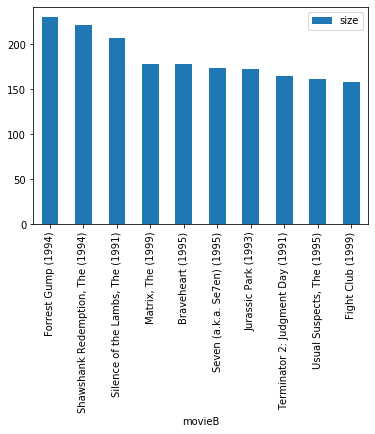

In [42]:
movie_Pulp=combinations_counts_df[combinations_counts_df.movieA == 'Pulp Fiction (1994)'].head(10)
movie_Pulp.plot.bar(x='movieB')

In [26]:
test=pd.DataFrame(list(permutations(range(3), 2) ), columns=['mov1', 'mov2'])
test.groupby(['mov1','mov2']).size()

mov1  mov2
0     1       1
      2       1
1     0       1
      2       1
2     0       1
      1       1
dtype: int64

In [35]:
combinations_counts_df.movieA.value_counts()


Forrest Gump (1994)                          9318
Matrix, The (1999)                           9071
Pulp Fiction (1994)                          8939
Star Wars: Episode IV - A New Hope (1977)    8906
Silence of the Lambs, The (1991)             8904
                                             ... 
Delirium (2014)                                20
One I Love, The (2014)                         20
Come See the Paradise (1990)                   20
Laggies (2014)                                 20
Circus (2000)                                  20
Name: movieA, Length: 9719, dtype: int64

In [39]:
movie_Pulp.head().sort

,movieA,movieB,size
18564136,Pulp Fiction (1994),'71 (2014),1
18564137,Pulp Fiction (1994),'Hellboy': The Seeds of Creation (2004),1
18564138,Pulp Fiction (1994),'Round Midnight (1986),1
18564139,Pulp Fiction (1994),'Tis the Season for Love (2015),1
18564140,Pulp Fiction (1994),"'burbs, The (1989)",11


# Content-based models(static)
Content-based models is suitable for new items recommendation(cold start).Imagine there is a large retailer that has a constantly changing product line, with new items being added every day.As the recommendations are based on the item attributes rather than user feedback, Content-based recommendations can be made on never-before-purchased products.

## Data preprocessing for genres column
one column contains all genres and seperate genre with |

In [4]:
# read columns and dedup
movie_genre_df=pd.read_csv(r'Data\user_ratings.csv',usecols=['title','genres'])
movie_genre_df.drop_duplicates(inplace=True, ignore_index= True)
print(movie_genre_df.head())
movie_genre_df.info()

                         title                                       genres
0             Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1      Grumpier Old Men (1995)                               Comedy|Romance
2                  Heat (1995)                        Action|Crime|Thriller
3  Seven (a.k.a. Se7en) (1995)                             Mystery|Thriller
4   Usual Suspects, The (1995)                       Crime|Mystery|Thriller
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9724 entries, 0 to 9723
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9724 non-null   object
 1   genres  9724 non-null   object
dtypes: object(2)
memory usage: 152.1+ KB


In [5]:
# split the genres
geners=movie_genre_df['genres'].str.split('|',expand=True)
movie_genre_df=pd.concat([movie_genre_df,geners], axis=1)
# melt all columns together
movie_genre_df =pd.melt(movie_genre_df,id_vars=['title'], value_vars=[0,1,2,3,4,5,6,7,8,9])
# Drop records with null values
movie_genre_df.dropna(inplace=True)
movie_genre_df.drop('variable',axis=1, inplace= True)
movie_genre_df.drop_duplicates(inplace =True, ignore_index= True)
movie_genre_df.rename(columns={'value':'genre_list'}, inplace=True)
# test the data quality
print(movie_genre_df[movie_genre_df.title=='Toy Story (1995)'])
movie_genre_df.info()

                  title genre_list
0      Toy Story (1995)  Adventure
9721   Toy Story (1995)  Animation
16598  Toy Story (1995)   Children
20259  Toy Story (1995)     Comedy
21594  Toy Story (1995)    Fantasy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22036 entries, 0 to 22035
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       22036 non-null  object
 1   genre_list  22036 non-null  object
dtypes: object(2)
memory usage: 344.4+ KB


In [40]:
# Create cross-tabulated DataFrame from name and genre_list columns
movie_cross_table = pd.crosstab(movie_genre_df['title'],movie_genre_df['genre_list'])
movie_cross_table[movie_cross_table.index.isin(['Toy Story (1995)','Yogi Bear (2010)'])]

genre_list,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Yogi Bear (2010),0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Comparing individual movies with Jaccard similarity
$J(A,B)= \dfrac{A \cap B}{A \cup B}$  

find most similar items of the item

In [45]:
from sklearn.metrics import jaccard_score
import numpy as np
# from scipy

### Find similarity  between assigned pairs

In [57]:
# use jaccard_score to compare individual items. It needs to change to numpy array first
# Toy Story, and GoldenEye with SkyFall and compare the results.
# method1- get numpy array values
Toy = movie_cross_table.loc['Toy Story (1995)'].to_numpy()
GoldenEye = movie_cross_table.loc['GoldenEye (1995)'].to_numpy()
Skyfall = movie_cross_table.loc['Skyfall (2012)'].to_numpy()
# method2 - get numpy array values
Toy = movie_cross_table.loc['Toy Story (1995)'].values
GoldenEye = movie_cross_table.loc['GoldenEye (1995)'].values
Skyfall = movie_cross_table.loc['Skyfall (2012)'].values
ic(jaccard_score(Toy, GoldenEye))
ic(jaccard_score(Skyfall, GoldenEye))

ic| jaccard_score(Toy, GoldenEye): 0.14285714285714285
ic| jaccard_score(Skyfall, GoldenEye): 0.75


0.75

### Comparing all  movies at once
When finding the similarities between the rows in a DataFrame, we could run through all pairs and calculate them individually, but it's more efficient to use the **pdist()** (pairwise distance) function from [scipy].

This can be reshaped into the desired rectangular shape using squareform() from the same library. Since you want similarity values as opposed to distances, you should subtract the values from 1.

In [59]:
from scipy.spatial.distance import pdist,squareform

In [68]:
# Calculate all pairwise distances
jaccard_distances = pdist(movie_cross_table.values, metric='jaccard')
jaccard_similarity = 1- squareform(jaccard_distances)
jaccard_similarity_df = pd.DataFrame(jaccard_similarity, columns=movie_cross_table.index, index=movie_cross_table.index)
jaccard_similarity_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.125,0.200000,0.333333,0.200000,0.0,0.0,0.25,0.166667,0.000000,...,0.40,0.40,0.2,0.2,0.200000,0.400000,0.400000,0.400000,0.000000,0.000000
'Hellboy': The Seeds of Creation (2004),0.125000,1.000,0.000000,0.000000,0.000000,0.0,0.2,0.00,0.142857,0.285714,...,0.00,0.00,0.0,0.0,0.000000,0.142857,0.142857,0.142857,0.166667,0.166667
'Round Midnight (1986),0.200000,0.000,1.000000,0.200000,0.333333,0.0,0.0,0.50,0.250000,0.000000,...,0.25,0.25,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333
'Salem's Lot (2004),0.333333,0.000,0.200000,1.000000,0.200000,0.0,0.0,0.25,0.166667,0.000000,...,0.40,0.75,0.5,0.5,0.200000,0.166667,0.166667,0.166667,0.000000,0.000000
'Til There Was You (1997),0.200000,0.000,0.333333,0.200000,1.000000,0.5,0.0,0.50,0.666667,0.000000,...,0.25,0.25,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000


In [91]:
# Find the recommendations for the movie Thor
print (jaccard_similarity_df.loc['Thor (2011)'].sort_values(ascending=False).head())



title
Thor (2011)                                              1.000000
Harry Potter and the Deathly Hallows: Part 2 (2011)      0.833333
Beowulf & Grendel (2005)                                 0.800000
In the Name of the King III (2014)                       0.800000
Lord of the Rings: The Return of the King, The (2003)    0.800000
Name: Thor (2011), dtype: float64


In [304]:
# find full movie name contains the key words


for title in movie_cross_table.index.to_list():
    if re.match(r'Forrest',title):
        print(title)


Forrest Gump (1994)


## Text based similarities
Based on the description of the items to find similarities

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [93]:
df_plots = pd.read_csv(r'Data\movie_plots.csv',sep='|')
df_plots.head()

,Title,Plot
0,Ace Ventura: When Nature Calls,"In the Himalayas, after a failed rescue missio..."
1,Dracula: Dead and Loving It,Solicitor Thomas Renfield travels all the way ...
2,Father of the Bride Part II,The film begins five years after the events of...
3,Four Rooms,"The film is set on New Year\'s Eve, and starts..."
4,Grumpier Old Men,The feud between Max (Walter Matthau) and John...


In [99]:
# To do
# need to add stop words and stem
Tfidf = TfidfVectorizer(min_df=0.2, max_df=0.8)

# Fit and transform the plot column
vectorized_data =Tfidf.fit_transform(df_plots.Plot)
print(Tfidf.get_feature_names())

['again', 'agent', 'agents', 'all', 'allows', 'also', 'another', 'appears', 'around', 'arrives', 'asks', 'attack', 'attacked', 'attempts', 'away', 'baby', 'back', 'ball', 'because', 'become', 'becomes', 'been', 'before', 'begin', 'begins', 'being', 'between', 'both', 'box', 'bring', 'british', 'burns', 'business', 'calls', 'can', 'car', 'children', 'come', 'comes', 'containing', 'crew', 'crime', 'daughter', 'day', 'dead', 'death', 'decides', 'deduces', 'despite', 'discovered', 'discovers', 'doctor', 'does', 'down', 'during', 'each', 'earlier', 'empty', 'end', 'ends', 'entire', 'escape', 'escapes', 'events', 'eventually', 'explodes', 'failed', 'fails', 'falls', 'family', 'father', 'female', 'fight', 'film', 'finally', 'find', 'finds', 'first', 'five', 'floor', 'follow', 'following', 'follows', 'forces', 'french', 'friends', 'front', 'full', 'game', 'get', 'gets', 'gives', 'go', 'goes', 'group', 'had', 'hand', 'have', 'having', 'head', 'heads', 'helicopter', 'help', 'her', 'herself', 'hi

In [103]:
# Create Dataframe from TF-IDFarray
tfidf_df = pd.DataFrame(vectorized_data.toarray(),index=df_plots['Title'],columns= Tfidf.get_feature_names())
tfidf_df

,again,agent,agents,all,allows,also,another,appears,around,arrives,...,what,where,which,wife,window,women,world,worried,years,young
Title,,,,,,,,,,,,,,,,,,,,,
Ace Ventura: When Nature Calls,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.049654,0.000000,0.000000,0.000000,0.000000,0.000000,0.063683,0.076918
Dracula: Dead and Loving It,0.000000,0.000000,0.000000,0.045420,0.000000,0.000000,0.000000,0.000000,0.061120,0.049745,...,0.000000,0.153480,0.035414,0.000000,0.061120,0.000000,0.000000,0.000000,0.000000,0.000000
Father of the Bride Part II,0.139330,0.000000,0.000000,0.103542,0.000000,0.000000,0.046443,0.000000,0.092887,0.000000,...,0.041687,0.029156,0.053821,0.000000,0.000000,0.046443,0.000000,0.046443,0.034514,0.083373
Four Rooms,0.000000,0.000000,0.000000,0.045084,0.000000,0.000000,0.060667,0.182001,0.060667,0.148129,...,0.108907,0.000000,0.281216,0.242668,0.060667,0.060667,0.000000,0.000000,0.045084,0.000000
Grumpier Old Men,0.095830,0.000000,0.000000,0.071215,0.000000,0.095830,0.000000,0.000000,0.000000,0.000000,...,0.172031,0.000000,0.000000,0.095830,0.000000,0.000000,0.000000,0.095830,0.000000,0.000000
Jumanji,0.000000,0.000000,0.000000,0.000000,0.000000,0.056982,0.000000,0.056982,0.000000,0.092755,...,0.000000,0.071545,0.033017,0.000000,0.000000,0.000000,0.000000,0.000000,0.127037,0.051146
Sudden Death,0.000000,0.157340,0.078670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.098776,0.045583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070612
Tom and Huck,0.084471,0.000000,0.000000,0.062774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.053030,0.097889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Toy Story,0.000000,0.000000,0.000000,0.000000,0.076152,0.000000,0.076152,0.076152,0.000000,0.000000,...,0.068353,0.143422,0.000000,0.000000,0.076152,0.000000,0.076152,0.076152,0.000000,0.000000


In [104]:
# Calculate the cosine similarity of the plot df
from sklearn.metrics.pairwise import cosine_similarity

In [109]:
cosine_similarity_df=pd.DataFrame(cosine_similarity(tfidf_df), index=tfidf_df.index, columns = tfidf_df.index)
cosine_similarity_df


Title,Ace Ventura: When Nature Calls,Dracula: Dead and Loving It,Father of the Bride Part II,Four Rooms,Grumpier Old Men,Jumanji,Sudden Death,Tom and Huck,Toy Story,Waiting to Exhale,GoldenEye,Skyfall
Title,,,,,,,,,,,,
Ace Ventura: When Nature Calls,1.000000,0.279682,0.268677,0.300889,0.228632,0.191795,0.297266,0.299629,0.254151,0.124366,0.233164,0.232743
Dracula: Dead and Loving It,0.279682,1.000000,0.259304,0.246828,0.224588,0.322642,0.232483,0.242966,0.185156,0.408040,0.255133,0.368761
Father of the Bride Part II,0.268677,0.259304,1.000000,0.286947,0.337783,0.280673,0.235136,0.310931,0.403564,0.209359,0.124531,0.230973
Four Rooms,0.300889,0.246828,0.286947,1.000000,0.410062,0.244001,0.199342,0.278238,0.342591,0.244965,0.173638,0.232016
Grumpier Old Men,0.228632,0.224588,0.337783,0.410062,1.000000,0.313377,0.181871,0.314681,0.292407,0.236601,0.080654,0.208161
Jumanji,0.191795,0.322642,0.280673,0.244001,0.313377,1.000000,0.421199,0.221790,0.266532,0.189061,0.188060,0.188356
Sudden Death,0.297266,0.232483,0.235136,0.199342,0.181871,0.421199,1.000000,0.270802,0.313847,0.157029,0.288196,0.205438
Tom and Huck,0.299629,0.242966,0.310931,0.278238,0.314681,0.221790,0.270802,1.000000,0.282996,0.161741,0.209461,0.286117
Toy Story,0.254151,0.185156,0.403564,0.342591,0.292407,0.266532,0.313847,0.282996,1.000000,0.113273,0.194207,0.277966


In [115]:
# find the recommendation of movie Toy Story
cosine_similarity_df.loc['Toy Story'].sort_values(ascending=False)[1:]

Title
Father of the Bride Part II       0.403564
Four Rooms                        0.342591
Sudden Death                      0.313847
Grumpier Old Men                  0.292407
Tom and Huck                      0.282996
Skyfall                           0.277966
Jumanji                           0.266532
Ace Ventura: When Nature Calls    0.254151
GoldenEye                         0.194207
Dracula: Dead and Loving It       0.185156
Waiting to Exhale                 0.113273
Name: Toy Story, dtype: float64

## User Profile recommendation
 how to create recommendations based on a user and all the items they liked
 * Caluculate the user's like movies average Tf-idf value and save as user profile
 * Calculate the similarity of the left movies' tfidf value and user profile to find similar ones

In [127]:
list_of_movies_enjoyed = ['GoldenEye', 'Skyfall', 'Toy Story']

# Create a subset of only the movies the user has enjoyed
movies_enjoyed_df = tfidf_df.reindex(list_of_movies_enjoyed)
# user mean value as user profile
user_profile = movies_enjoyed_df.mean()
print(user_profile)

again      0.000000
agent      0.050250
agents     0.076282
all        0.017997
allows     0.075634
             ...   
women      0.000000
world      0.049601
worried    0.025384
years      0.017997
young      0.000000
Length: 238, dtype: float64


In [150]:
# Extract the movies' dataFrame that not in list_of_movies_enjoyed
# method1 
tfidf_subset_df = tfidf_df[~tfidf_df.index.isin(list_of_movies_enjoyed)]
# method 2
tfidf_subset_df = tfidf_df.drop(list_of_movies_enjoyed,axis=0)

similarity = cosine_similarity(user_profile.values.reshape(1,-1), tfidf_subset_df)
#  similarity.T and similarity.reshape(-1,1) both work
similarity_df = pd.DataFrame(similarity.reshape(-1,1), index = tfidf_subset_df.index, columns=['SimilarityScore'])
similarity_df.sort_values(by='SimilarityScore', ascending = False).head()

,SimilarityScore
Title,
Dracula: Dead and Loving It,0.365692
Sudden Death,0.364983
Tom and Huck,0.351916
Father of the Bride Part II,0.343100
Four Rooms,0.338208


# Collaborative filtering(Dynamic)
Collaborative filtering is built around the premise that users who have ranked items similarly in the past have similar tastes, and therefore are likely to rate new items in a similar fashion.
* user based
* Item based
* Using KNN 

## Prepare data
* create user moving rating table
* Duplicate ratings-- use mean ratings
* Missing data - whole matrix subtract each user's mean rating and then fill 0 to avoid bias the data

In [170]:
# check duplication
ic(user_ratings_df.duplicated(['userId','title']).sum())
ic(user_ratings_df[user_ratings_df.duplicated(['userId','title'],keep=False)==True].sort_values(by=['userId','title']))
user_ratings = user_ratings_df.groupby(['userId','title'],as_index =False).rating.mean()

ic| user_ratings_df.duplicated(['userId','title']).sum(): 4
ic| user_ratings_df[user_ratings_df.duplicated(['userId','title'],keep=False)==True].sort_values(by=['userId','title']):        userId  movieId  rating                                   title
                                                                                                                         39411      28    34048     3.5                War of the Worlds (2005)
                                                                                                                         73911      28    64997     3.5                War of the Worlds (2005)
                                                                                                                         39412      68    34048     2.0                War of the Worlds (2005)
                                                                                                                         73912      68    64997     2.5                War o

In [171]:
# create user rating tables
user_ratings_table =user_ratings.pivot(index='userId',columns='title', values='rating')
user_ratings_table.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For most datasets, the majority of users will have rated only a small number of items.we should fill in missing data with information that should not bias the data that we do have.
* Get the average score each user has given across all their ratings;
* use this average to center the users' scores around zero.
* Finally, fill in the empty values with zeros, which is now a neutral score, minimizing the impact on their overall profile, but still allowing the comparison of users.

In [175]:
# Get the average rating for each user 
avg_ratings = user_ratings_table.mean(axis=1)

In [181]:
# Center each users ratings around 0
user_ratings_table_centered =user_ratings_table.sub(avg_ratings, axis=0)
# Fill in the missing data with 0s
user_ratings_table_normed = user_ratings_table_centered.fillna(0)
user_ratings_table_normed.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.366379,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## User based vs Item basd recommendation
find items that users, similar to the one you are making recommendations for, have liked.
* User-based recommendations compare amongst users, we use user-based data to find similar users based on how they rated different movies
* item-based recommendations compare different items. We use item-based data to find similar movies based on how they have been rated by the users.  

|User|MovieA|MovieB|MovieC|MovieD|
|:--|:-------:|:-------:|:-----:|-----:|
|User_A|1|4|1|5|
|User_B|1|5|1|4|
|User_C|4|2|5|2|
|User_D|4|1|4|2|

* User-based: User_A similar to User_B
* Item-based: MovieA similare to MovieC

## Item based recommendation
Someone's honey is someone's poison. This might reflect the type of movie far more than its quality. Take, for example, horror movies — many people absolutely love them, while others hate them.

In [182]:
movie_ratings_table_normed = user_ratings_table_normed.T
movie_ratings_table_normed.head(2)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311444
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [191]:
# Check the similarity of star wars series as example
sw_IV = movie_ratings_table_normed.loc['Star Wars: Episode IV - A New Hope (1977)',:].values.reshape(1,-1)
sw_V = movie_ratings_table_normed.loc['Star Wars: Episode V - The Empire Strikes Back (1980)', :].values.reshape(1, -1)
cosine_similarity(sw_IV,sw_V)

array([[0.69423917]])

In [194]:
# calculate the similarity of the whole items set
movie_ratings_similarity_df=pd.DataFrame(cosine_similarity(movie_ratings_table_normed),
                                         index = movie_ratings_table_normed.index,
                                         columns= movie_ratings_table_normed.index)

In [197]:
# Find the similarity values for a specific movie:'Star Wars: Episode IV - A New Hope (1977)'
movie_ratings_similarity_df.loc['Star Wars: Episode IV - A New Hope (1977)'].sort_values(ascending= False)[1:10]

title
Star Wars: Episode V - The Empire Strikes Back (1980)                             0.694239
Star Wars: Episode VI - Return of the Jedi (1983)                                 0.646330
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    0.449865
Indiana Jones and the Last Crusade (1989)                                         0.404551
Godfather, The (1972)                                                             0.388623
Back to the Future (1985)                                                         0.383780
Princess Bride, The (1987)                                                        0.379710
Godfather: Part II, The (1974)                                                    0.341717
Lord of the Rings: The Return of the King, The (2003)                             0.338377
Name: Star Wars: Episode IV - A New Hope (1977), dtype: float64

## K-Nearest Neighbours

###  Step through KNN(user based recommendation as example)
working with user_001's similarity scores, find their nearest neighbors, and based on the ratings those neighbors gave a movie, infer what rating user_001 might give it if they saw it.

#### create user similarity table

In [206]:
user_ratings_similarity_df=pd.DataFrame(cosine_similarity(user_ratings_table_normed),
                                        index = user_ratings_table_normed.index,
                                        columns = user_ratings_table_normed.index)


#### Explore the K nearest neighbours manually

In [214]:
# Finde 10 nearest neighbours
nearestNeighbours = user_ratings_similarity_df.loc[1].sort_values(ascending = False)[1:11].index
nearestNeighbours

Int64Index([301, 597, 414, 477, 57, 369, 206, 535, 590, 418], dtype='int64', name='userId')

In [224]:
neighbourRating = user_ratings_table.loc[nearestNeighbours]
ic(neighbourRating['Titanic (1997)'].mean())

ic| neighbourRating['Titanic (1997)'].mean(): 2.9375


2.9375

In [300]:
# manually check how similiar of the user 1 and 301
# method1
user1_301=user_ratings_df.iloc[user_ratings_df[user_ratings_df.userId.isin([1,301])].index]
user1_301.pivot(index='userId', columns='title',values='rating').dropna(axis=1)
# method2
user_ratings_table.iloc[[0,300]].dropna(axis=1)

title,American Beauty (1999),American History X (1998),Back to the Future (1985),Braveheart (1995),Clear and Present Danger (1994),Dumb & Dumber (Dumb and Dumber) (1994),E.T. the Extra-Terrestrial (1982),Edward Scissorhands (1990),Face/Off (1997),Fargo (1996),...,Mission: Impossible (1996),Mrs. Doubtfire (1993),"Mummy, The (1999)",Pulp Fiction (1994),"Rock, The (1996)",Schindler's List (1993),Seven (a.k.a. Se7en) (1995),"Terminator, The (1984)",Twister (1996),"Usual Suspects, The (1995)"
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,...,3.0,3.0,2.0,3.0,4.0,5.0,5.0,5.0,3.0,5.0
301,4.0,4.5,2.5,1.5,4.0,4.0,4.0,4.0,4.5,3.0,...,2.5,3.5,0.5,4.5,0.5,4.5,4.5,0.5,1.0,4.5


#### Using KNN in sklearn
step through how to prepare the data for scikit-learn's KNN model, and then use it to make inferences about what rating a user might give a movie they haven't seen.
For consistency, still work with User_1 and the rating they would give Titanic (1997) if they saw it.

In [228]:
# for using knn in sklearn, we need to use standardlizednormalized data set 
# create a new df withouth the column you are trying to predict
user_ratings_table_normed_copy = user_ratings_table_normed.copy(deep = True)
user_ratings_table_normed_copy.drop('Titanic (1997)',axis=1,inplace= True)

In [254]:
# Get the data for the user you are predicting for
target_user_x = user_ratings_table_normed_copy.loc[[1]]
other_user_y = user_ratings_table['Titanic (1997)']

In [255]:
# Centered ratings for all other users and the movies they have rated excluding the movie Titanic (1997).
other_user_x = user_ratings_table_normed_copy[other_user_y.notnull()]
# Raw ratings that all other users have given the movie Titanic (1997).
other_user_y.dropna(inplace = True)

In [256]:
from sklearn.neighbors import KNeighborsRegressor
knn= KNeighborsRegressor(n_neighbors=10, metric ='cosine')
knn.fit(other_user_x, other_user_y)
knn.predict(target_user_x)

array([2.75])

### Item_based vs User_based
we look at two different KNN approaches. 
* item-item KNN where we use the average of the  most similar movies that a user has rated to suggest a rating for a movie they haven't watched. 
* user-user KNN where we use the average of the ratings that the  most similar users gave the movie to suggest what rating the target user would give the movie.  


1. Item-item
    * is often easy to explain and more relative
    * allows for similarity to be precalculated
    * is more consistent over time  


2. user_user
  * generally creates more suprising/unexpected, but still relavent suggestions

we compare the two and calculate what rating userId as 2 would give to Forrest Gump.

In [319]:
# Prepare the user_user data
user_ratings_table_normed_copy = user_ratings_table_normed.copy(deep = True)
user_ratings_table_normed_copy.drop('Forrest Gump (1994)',axis=1, inplace =True)
otherUsers_exclude2_y = user_ratings_table['Forrest Gump (1994)']
targetUsers_x =  user_ratings_table_normed_copy.loc[[2]]
otherUsers_exclude2_x = user_ratings_table_normed_copy[otherUsers_exclude2_y.notnull()]
otherUsers_exclude2_y.dropna(inplace = True)

In [339]:
# Prepare the item_item data
movie_ratings_table_normed_copy = movie_ratings_table_normed.copy(deep = True)
movie_ratings_table_normed_copy.drop(2, axis=1,inplace =True)
targetMovie_x = movie_ratings_table_normed_copy.loc[['Forrest Gump (1994)']]
otherMovies_excludeFG_y = user_ratings_table.T[2]
otherMovies_excludeFG_x = movie_ratings_table_normed_copy[otherMovies_excludeFG_y.notnull()]
otherMovies_excludeFG_y.dropna(inplace = True)

In [346]:
# Instantiate the user KNN model
user_knn = KNeighborsRegressor()

# Fit the model and predict the target user
user_knn.fit(otherUsers_exclude2_x,otherUsers_exclude2_y )
print("The user-user model predicts {}".format(user_knn.predict(targetUsers_x)))

item_knn = KNeighborsRegressor()
item_knn.fit(otherMovies_excludeFG_x, otherMovies_excludeFG_y)
print("The user-user model predicts {}".format(item_knn.predict(targetMovie_x)))
      
      

The user-user model predicts [4.4]
The user-user model predicts [4.]


userId,1,3,4,5,6,7,8,9,10,11,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
Collateral (2004),0.0,0.0,0.0,0.0,0.0,1.269737,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.865824,0.0,0.811444
"Dark Knight Rises, The (2012)",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.721429,0.0,...,0.074257,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.811444
"Dark Knight, The (2008)",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.221429,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.811444
"Departed, The (2006)",0.0,0.0,0.0,0.0,0.0,-2.230263,0.0,0.0,0.000000,0.0,...,0.574257,0.0,0.0,0.0,0.0,-0.157399,0.0,0.000000,0.0,1.311444
Django Unchained (2012),0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,-0.425743,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.811444


In [333]:
user_ratings_table.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
user_ratings_table_normed_copy.loc[[2]]

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [322]:
targetUsers_x.shape

(1, 9718)